In [1]:
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torchvision
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [2]:
# Custom PyTorch Dataset to load COCO-format annotations and images
class CocoSegmentationDataset(Dataset):
    # Init function: loads annotation file and prepares list of image id's
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        root_dir: path to the folder containing images (e.g. car_parts_dataset/train/)
        annotation_file: path to the COCO annotations (e.g. car_parts_dataset/train/_annotations.coco.json)
        """
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms
    
    # Returns total number of images
    def __len__(self):
        return len(self.image_ids)

    # Fetches a single image and its annotations
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info["file_name"])
        image = Image.open(image_path).convert("RGB")
        
        # Load all annotations for this image
        annotation_ids = self.coco.getAnnIds(imgIds=image_id)
        annotations = self.coco.loadAnns(annotation_ids)
        
         # Extract segmentation masks,bounding boxes and labels from annotations
        boxes = []
        labels = []
        masks = []
        
        for ann in annotations:
            xmin, ymin, w, h = ann['bbox']
            xmax = xmin + w
            ymax = ymin + h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(ann['category_id'])
            mask = self.coco.annToMask(ann)
            masks.append(mask)
        
        boxes = torch.as_tensor( np.array(boxes), dtype=torch.float32) #numpy.array()
        labels = torch.as_tensor( np.array(labels), dtype=torch.int64)
        masks = torch.as_tensor( np.array(masks), dtype=torch.uint8)


        area = torch.as_tensor([ann['area'] for ann in annotations], dtype=torch.float32)
        iscrowd = torch.as_tensor([ann.get('iscrowd', 0) for ann in annotations], dtype=torch.int64)
        
        # store everything in a dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        # Apply transforms
        # prev_size = torchvision.transforms.ToTensor()(image).shape[1:][0] ###
        if self.transforms:
            # prev_size = torchvision.transforms.ToTensor()(image).shape[1:][0] ###
            image = self.transforms(image)
        #     ###
        # if image.shape[1:][0] > prev_size:
        #     masks1 = list()
        #     boxes1 = list()
        #     for mask in target["masks"]: #.cpu().numpy():
        #         mask1 = cv2.resize(mask.cpu().numpy(), dsize=(image.shape[1:]))
        #         masks1.append(mask1)
        #         box, hierarchy=cv2.findContours( mask1 ,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)
        #         for b in box:
        #             x1, y1, w, h = cv2.boundingRect(b) #map(int, box)
        #             boxes1.append( [x1, y1, x1+w, y1+h] )
        #     boxes1 = torch.as_tensor( np.array(boxes1), dtype=torch.float32)
        #     masks1 = torch.as_tensor( np.array(masks1), dtype=torch.uint8)

        #     target['boxes'] = boxes1
        #     target['masks'] = masks1
        #     ###


        
         # Return the processed image and its annotations
        return image, target

In [3]:
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader

data_transform = transforms.Compose([
    # transforms.Resize( (800, 800),),
                    #   interpolation=transforms.InterpolationMode.NEAREST,
                    #   max_size=),
    ToTensor(),
    # transforms.Normalize( (.5, .5, .5), (.5, .5, .5))
])

train_dataset = CocoSegmentationDataset(
    root_dir='apple_leaf_dataset/rcnn/train_coco3/images',
    annotation_file='apple_leaf_dataset/rcnn/train_coco3/result.json',
    transforms=data_transform  #ToTensor()  # define this if needed
)

valid_dataset = CocoSegmentationDataset(
    root_dir='apple_leaf_dataset/rcnn/valid_coco/images',
    annotation_file='apple_leaf_dataset/rcnn/valid_coco/result.json',
    transforms=data_transform #ToTensor()
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)),
                          num_workers=8)
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)),
                        num_workers=0)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [5]:
# # Label list 
CLASS_NAMES = [
    "scab", "Black_rot", "Cedar_rust", "Leaf"
]

# Label list 
# CLASS_NAMES = [
#     "Disease", "Disease", "Disease", "Leaf"
# ]


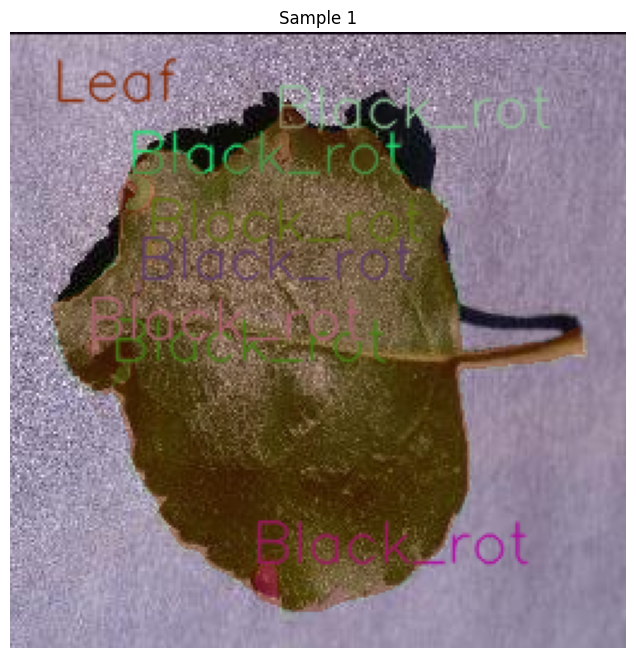

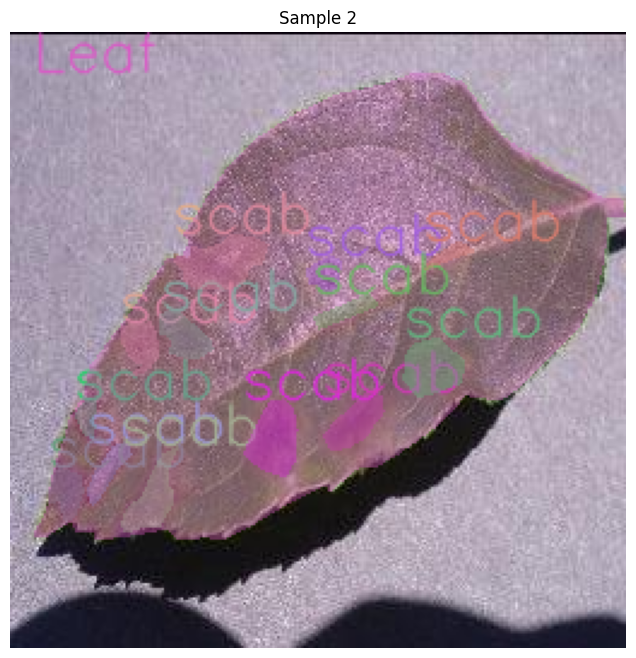

In [8]:
# Sample a batch
images, targets = next(iter(train_loader))

for i in range(len(images)):
    # Convert image tensor to numpy array
    image = images[i].permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    overlay = image.copy()
    
    # Extract masks, bounding boxes, and labels for the current image
    masks = targets[i]['masks'].cpu().numpy()
    boxes = targets[i]['boxes'].cpu().numpy()
    labels = targets[i]['labels'].cpu().numpy()

    for j in range(len(masks)):
        mask = masks[j]
        box = boxes[j]
        label_id = labels[j]

        # box = np.array(
        #     [x if x <= 255.0 else x for x in box*10]
        # )
        # mask = cv2.resize(mask, dsize=(image.shape[:2]))
        # box, hierarchy=cv2.findContours( mask ,cv2.RETR_LIST,cv2.CHAIN_APPROX_NONE)

        # Get class name from mapping
        class_name = CLASS_NAMES[label_id]  # assuming 0-based labels

        # Random color
        color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

        # Alpha blend mask
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]
        alpha = 0.4
        overlay = np.where(mask[..., None], 
                           ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8), 
                           overlay)

        # Draw label
        x1, y1, x2, y2 = map(int, box)
        cv2.putText(overlay, class_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                    0.8, color, 1, lineType=cv2.LINE_AA)
        # for b in box:
        #     x1, y1, x2, y2 = cv2.boundingRect(b) #map(int, box)
        #     cv2.putText(overlay, class_name, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
        #                 0.8, color, 2, lineType=cv2.LINE_AA)


    # Show the result
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Sample {i + 1}")
    plt.show()

## Buat Model

In [9]:
import torch
import torchvision
from torchvision.models import MobileNet_V2_Weights
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

from library_buatan.holdout_workflow_comvis import Holdout_Workflow_CV
from library_buatan.holdout_workflow_comvisV2 import Holdout_Workflow_CV2
# from mobilenetv2cbam.mobilenetv2cbam_hilmi import MobileNetV2_CBAM_hilmi
# from mobilenetv2.mobilenetv2 import MobileNetV2
# from basic_workflow_comvis import Pov2ImageDataset_V4

import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision import models
from torchvision.models.mobilenetv3 import _mobilenet_v3_conf

In [ ]:
# class MobileNetV3Backbone(torch.nn.Module):
#     def __init__(self, model):
#         super().__init__()
#         self.features = model.features
#         self.out_channels = 576  # final conv output

#     def forward(self, x):
#         x = self.features(x)
#         return {"0": x}


In [10]:
# ---------------------------------------
# 1. Load backbone MobileNetV2 (pretrained)
# ---------------------------------------
inverted_residual_setting, last_channel = _mobilenet_v3_conf('mobilenet_v3_small')
model1 = models.MobileNetV3(inverted_residual_setting=inverted_residual_setting,
                    last_channel=last_channel,
                    num_classes=4) #MobileNetV2_CBAM_hilmi(10)
# backbone = torchvision.models.mobilenet_v2(
#     weights=MobileNet_V2_Weights.DEFAULT
# ).features
# load_state_dict(torch.load(f"{save_path}/{name_file}.pth") )
model1.load_state_dict(torch.load(f"hasil/mobilenetv3small/apple_leaf_disease_20_mobilenetv3small_Adam_default_outchan1280_16batch/apple_leaf_disease_20_mobilenetv3small_Adam_default_outchan1280_16batch.pth") )

backbone = model1.features
# backbone = MobileNetV3Backbone(model1)

# Mask R-CNN membutuhkan jumlah output channel dari backbone.
# Untuk MobileNetV2, jumlah output channel = 1280.
backbone.out_channels = 576 #4

# ---------------------------------------
# 2. Anchor Generator (RPN)
# ---------------------------------------
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),    # 5 ukuran anchor
    aspect_ratios=((0.5, 1.0, 2.0),)     # 3 rasio anchor
)

# ---------------------------------------
# 3. ROI Poolers
# ---------------------------------------
roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],     # gunakan feature map index 0
    output_size=7,
    sampling_ratio=2
)

mask_roi_pooler = MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=14,
    sampling_ratio=2
)

# ---------------------------------------
# 4. Build Mask R-CNN Model
# ---------------------------------------
model = MaskRCNN(
    backbone=backbone,
    num_classes=5,                     # 4 objek + 1 background
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    mask_roi_pool=mask_roi_pooler
)
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1,

In [11]:
# ---------------------------------------
# 5. Inference
# ---------------------------------------
model.eval()

x = torch.rand(3, 800, 800).to(device)

with torch.no_grad():
    predictions = model( x.unsqueeze(0) )
print(predictions)

[{'boxes': tensor([[1.9030e+01, 5.1571e+02, 4.0084e+01, 5.1905e+02],
        [2.9472e+01, 4.8080e+02, 5.4831e+01, 4.8383e+02],
        [2.6922e+01, 4.4637e+02, 5.7778e+01, 4.4878e+02],
        [1.7745e+01, 4.1480e+02, 5.6870e+01, 4.1742e+02],
        [1.6787e+01, 2.8860e+02, 5.0378e+01, 2.9155e+02],
        [1.1157e+01, 5.5023e+02, 3.4300e+01, 5.5339e+02],
        [1.6673e+01, 6.6981e+02, 5.0859e+01, 6.7235e+02],
        [1.8163e+01, 2.5701e+02, 5.4348e+01, 2.6018e+02],
        [5.5684e-01, 4.5850e+02, 1.0520e+01, 4.6054e+02],
        [6.9811e-01, 4.9432e+02, 1.3512e+01, 4.9642e+02],
        [3.3155e-01, 4.2431e+02, 6.1732e+00, 4.2688e+02],
        [4.6780e-01, 6.4848e+02, 8.4474e+00, 6.5159e+02],
        [1.7385e+01, 7.0532e+02, 5.2052e+01, 7.0796e+02],
        [1.2084e+01, 0.0000e+00, 2.6398e+01, 4.4104e+02],
        [1.3410e-01, 3.9313e+02, 2.6636e+00, 3.9644e+02],
        [2.2945e+01, 8.0273e-01, 3.3273e+01, 5.0309e+02],
        [2.5693e-01, 2.9727e+02, 5.3578e+00, 3.0002e+02],
   

In [18]:
# params

In [12]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(params) #, lr=0.0005)

# Define the optimizer (Stochastic Gradient Descent) with learning rate, momentum, and weight decay
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)

In [20]:
# # Clone the PyTorch vision repository 
# !git clone https://github.com/pytorch/vision.git

# # Navigate to the 'vision' directory and copy necessary detection-related utility files
# !cd vision; cp references/detection/utils.py ../;  # Copy utility functions
# !cd vision; cp references/detection/transforms.py ../;  # Copy image transformation functions
# !cd vision; cp references/detection/coco_eval.py ../;  # Copy COCO evaluation script
# !cd vision; cp references/detection/engine.py ../;  # Copy engine code for training/evaluation
# !cd vision; cp references/detection/coco_utils.py ../;  # Copy COCO-specific utility functions


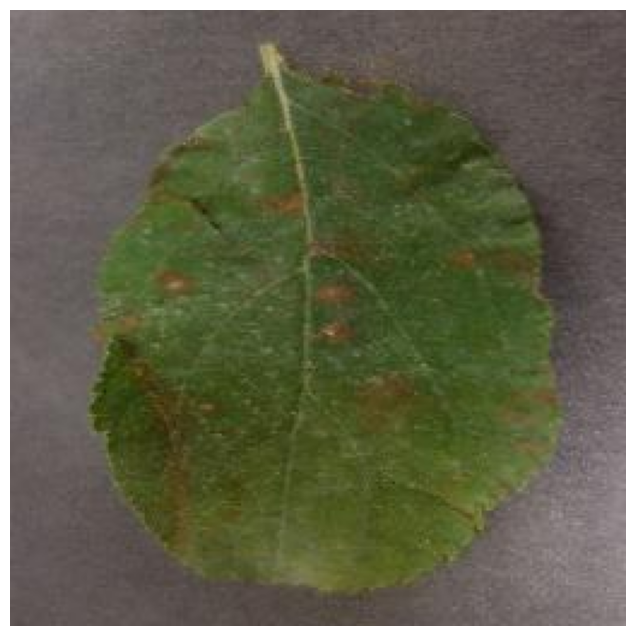

In [13]:
from torchvision import transforms

model.eval()

# Load image with OpenCV and convert to RGB
img_path = r"apple_leaf_dataset/rcnn/valid_rcnn/Apple___Cedar_apple_rust/5d4e82f2-d720-45fa-b913-13773583ee0f___FREC_C.Rust 4181_180deg.JPG"  # Change this path
image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image to tensor and add batch dimension
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract masks, boxes, labels, and scores
masks = predictions[0]['masks']       # [N, 1, H, W]
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

threshold = 0.4  # Confidence threshold

# Use overlay for blending masks over image
overlay = image_bgr.copy()

for i in range(len(masks)):
    if scores[i] > threshold:
        # Convert mask to uint8 numpy array (H,W)
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        mask_bool = mask > 127  # binary mask for indexing
        box = boxes[i].cpu().numpy().astype(int)
        class_name = CLASS_NAMES[labels[i]]
        score = scores[i].item()

        # Generate random color (BGR)
        color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

        # Create colored mask with the random color
        colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask_bool * color[c]

        # Alpha blend the colored mask onto the overlay
        alpha = 0.4
        overlay = np.where(mask_bool[:, :, None],
                           ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8),
                           overlay)

        # Draw bounding box and label text on overlay
        x1, y1, x2, y2 = box
        cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, lineType=cv2.LINE_AA)

# Show the result using matplotlib (convert BGR -> RGB)
result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(result_rgb)
plt.axis('off')
plt.show()

## Pelatihan Model

In [ ]:
# from engine import train_one_epoch, evaluate

# # Set the number of epochs for training
# num_epochs = 50

# # Loop through each epoch
# for epoch in range(num_epochs):
#     print(f"\nEpoch {epoch + 1}/{num_epochs}")

#     # Train the model for one epoch, printing status every 25 iterations
#     train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=25)  # Using train_loader for training

#     # Evaluate the model on the validation dataset
#     evaluate(model, val_loader, device=device)  # Using val_loader for evaluation

#     # Optionally, save the model checkpoint after each epoch
#     torch.save(model.state_dict(), f"model_epoch_mask_rcnn100.pth")

#     torch.cuda.empty_cache()


Epoch 1/50


/run/media/shared_storage/Documents/KuliahUbS1/Semester11_2025_2026/A_Pengolahan_Citra_Digital_dan_Visi_Komputer/tugas_kel_pcdvk/proyek_akhir/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [0/5]  eta: 0:00:05  lr: 0.000251  loss: 0.2827 (0.2827)  loss_classifier: 0.0419 (0.0419)  loss_box_reg: 0.0451 (0.0451)  loss_mask: 0.1581 (0.1581)  loss_objectness: 0.0192 (0.0192)  loss_rpn_box_reg: 0.0183 (0.0183)  time: 1.1379  data: 0.4194  max mem: 3796
Epoch: [0]  [4/5]  eta: 0:00:00  lr: 0.001000  loss: 0.4188 (0.4052)  loss_classifier: 0.0448 (0.0514)  loss_box_reg: 0.0856 (0.0791)  loss_mask: 0.2472 (0.2405)  loss_objectness: 0.0192 (0.0188)  loss_rpn_box_reg: 0.0164 (0.0155)  time: 0.8593  data: 0.0875  max mem: 3796
Epoch: [0] Total time: 0:00:04 (0.8649 s / it)
creating index...
index created!
Test:  [0/2]  eta: 0:00:02  model_time: 0.3303 (0.3303)  evaluator_time: 0.1314 (0.1314)  time: 1.0444  data: 0.5813  max mem: 3796
Test:  [1/2]  eta: 0:00:00  model_time: 0.3303 (0.3506)  evaluator_time: 0.0895 (0.1105)  time: 0.8684  data: 0.4061  max mem: 3796
Test: Total time: 0:00:01 (0.8689 s / it)
Averaged stats: model_time: 0.3303 (0.3506)  evaluator_time: 0.089

In [23]:
torch.cuda.empty_cache()

## Pengujian Model

In [ ]:
# Label list 
CLASS_NAMES = [
    "Scab", "Black_rot", "Cedar_rust", "Leaf"
]

# # Label list 
# CLASS_NAMES = [
#     "Disease", "Disease", "Disease", "Leaf"
# ]


In [18]:
# model.load_state_dict(torch.load(f"model_epoch_mask_rcnn100.pth") )
model.load_state_dict(torch.load(f"model_epoch_mask_rcnn200_scrap.pth") )

<All keys matched successfully>

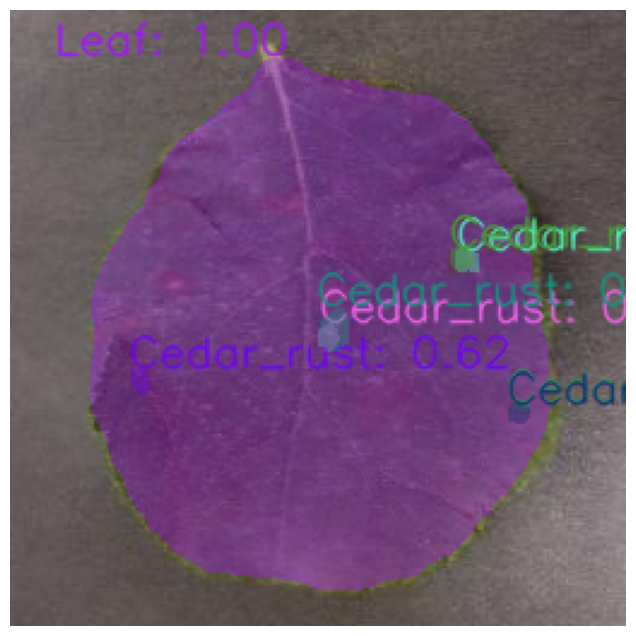

In [19]:
from torchvision import transforms

model.eval()

# Load image with OpenCV and convert to RGB
img_path = r"apple_leaf_dataset/rcnn/valid_rcnn/Apple___Cedar_apple_rust/5d4e82f2-d720-45fa-b913-13773583ee0f___FREC_C.Rust 4181_180deg.JPG"  # Change this path
# img_path = f"/run/media/shared_storage/Documents/KuliahUbS1/Semester11_2025_2026/A_Pengolahan_Citra_Digital_dan_Visi_Komputer/tugas_kel_pcdvk/proyek_akhir/apple_leaf_dataset/rcnn/valid_rcnn/Apple___healthy/9b0ebfaf-9d8f-4195-b2af-9505b5bc1f19___RS_HL 6212.JPG"

image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

# Transform image to tensor and add batch dimension
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image_pil).unsqueeze(0).to(device)

# Inference
with torch.no_grad():
    predictions = model(image_tensor)

# Extract masks, boxes, labels, and scores
masks = predictions[0]['masks']       # [N, 1, H, W]
boxes = predictions[0]['boxes']
labels = predictions[0]['labels']
scores = predictions[0]['scores']

threshold = 0.5 #0.4  # Confidence threshold

# Use overlay for blending masks over image
overlay = image_bgr.copy()

for i in range(len(masks)):
    if scores[i] >= threshold:
        # Convert mask to uint8 numpy array (H,W)
        mask = masks[i, 0].mul(255).byte().cpu().numpy()
        mask_bool = mask > 127  # binary mask for indexing
        box = boxes[i].cpu().numpy().astype(int)
        class_name = CLASS_NAMES[labels[i]]
        score = scores[i].item()

        # Generate random color (BGR)
        color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

        # Create colored mask with the random color
        colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask_bool * color[c]

        # Alpha blend the colored mask onto the overlay
        alpha = 0.4
        overlay = np.where(mask_bool[:, :, None],
                           ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8),
                           overlay)

        # Draw bounding box and label text on overlay
        x1, y1, x2, y2 = box
        # cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1 - 10),
        #             cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, lineType=cv2.LINE_AA)
        cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, color, 1, lineType=cv2.LINE_AA)

# Show the result using matplotlib (convert BGR -> RGB)
result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(result_rgb)
plt.axis('off')
plt.show()

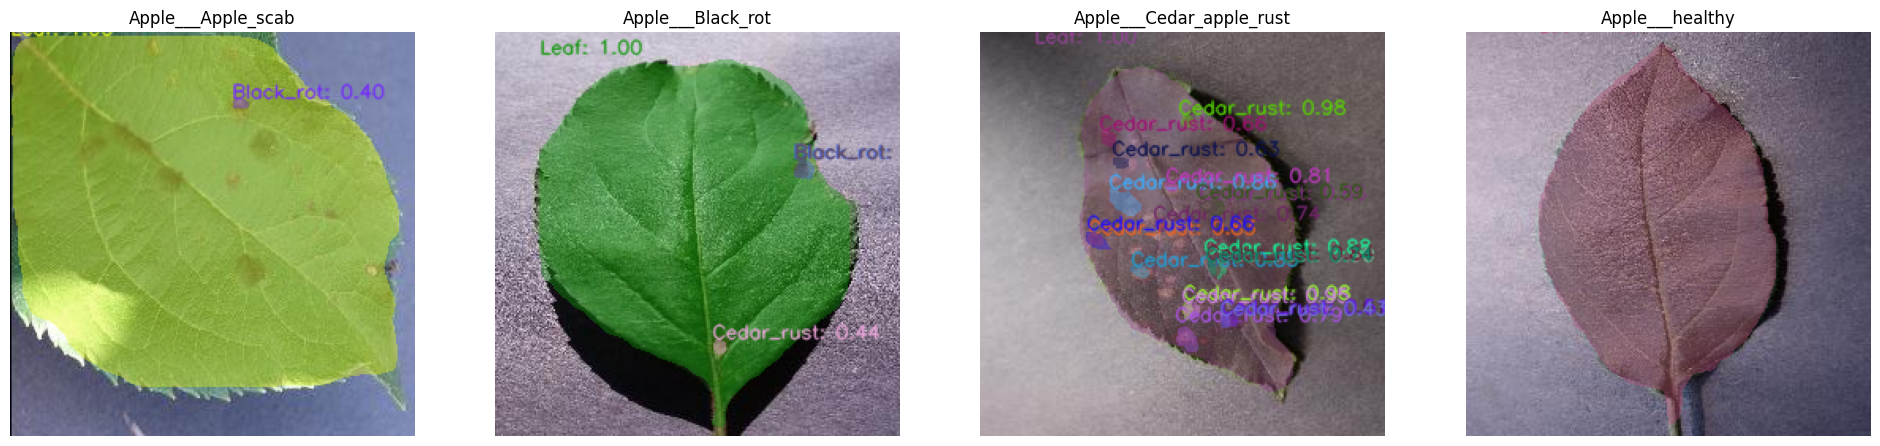

In [26]:
# path = 'apple_leaf_dataset/rcnn/valid_rcnn'
# target_folder = os.listdir(path)

# file = os.listdir( os.path.join( path, target_folder[0]) )[50]
# file
from torchvision import transforms


path = 'apple_leaf_dataset/rcnn/valid_rcnn'
target_folders = os.listdir(path)

fig, axs = plt.subplots( 1, len(target_folders), figsize=(24, 16))
# fig.figure()
# plt.figure(figsize=(24, 16))

for idx, target_folder in enumerate(target_folders):
    file = os.listdir( os.path.join( path, target_folder) )[0]

    model.eval()

    # Load image with OpenCV and convert to RGB
    # img_path = r"apple_leaf_dataset/rcnn/valid_rcnn/Apple___Cedar_apple_rust/5d4e82f2-d720-45fa-b913-13773583ee0f___FREC_C.Rust 4181_180deg.JPG"  # Change this path
    # img_path = f"/run/media/shared_storage/Documents/KuliahUbS1/Semester11_2025_2026/A_Pengolahan_Citra_Digital_dan_Visi_Komputer/tugas_kel_pcdvk/proyek_akhir/apple_leaf_dataset/rcnn/valid_rcnn/Apple___healthy/9b0ebfaf-9d8f-4195-b2af-9505b5bc1f19___RS_HL 6212.JPG"
    img_path = os.path.join(path, target_folder, file)

    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # Transform image to tensor and add batch dimension
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract masks, boxes, labels, and scores
    masks = predictions[0]['masks']       # [N, 1, H, W]
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    threshold = 0.4 #0.4  # Confidence threshold

    # Use overlay for blending masks over image
    overlay = image_bgr.copy()

    for i in range(len(masks)):
        if scores[i] >= threshold:
            # Convert mask to uint8 numpy array (H,W)
            mask = masks[i, 0].mul(255).byte().cpu().numpy()
            mask_bool = mask > 127  # binary mask for indexing
            box = boxes[i].cpu().numpy().astype(int)
            class_name = CLASS_NAMES[labels[i]]
            score = scores[i].item()

            # Generate random color (BGR)
            color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

            # Create colored mask with the random color
            colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
            for c in range(3):
                colored_mask[:, :, c] = mask_bool * color[c]

            # Alpha blend the colored mask onto the overlay
            alpha = 0.4
            overlay = np.where(mask_bool[:, :, None],
                            ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8),
                            overlay)

            # Draw bounding box and label text on overlay
            x1, y1, x2, y2 = box
            # cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1 - 10),
            #             cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, lineType=cv2.LINE_AA)
            cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                        0.4, color, 1, lineType=cv2.LINE_AA)

    # Show the result using matplotlib (convert BGR -> RGB)
    result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    axs[idx].imshow(result_rgb)
    axs[idx].set_title(target_folder)
    axs[idx].axis('off')
plt.show()

Berdasarkan sample di atas, model hanya condong mendeteksi penyakit Cedar_rust dan tidak dapat mendeteksi penyakit Scab. Oleh karena itu, kelompok kami memutuskan untuk mengubah model menjadi mendeteksi penyakit saja.

In [27]:
# # Label list 
# CLASS_NAMES = [
#     "scab", "Black_rot", "Cedar_rust", "Leaf"
# ]

# Label list 
CLASS_NAMES = [
    "Disease", "Disease", "Disease", "Leaf"
]


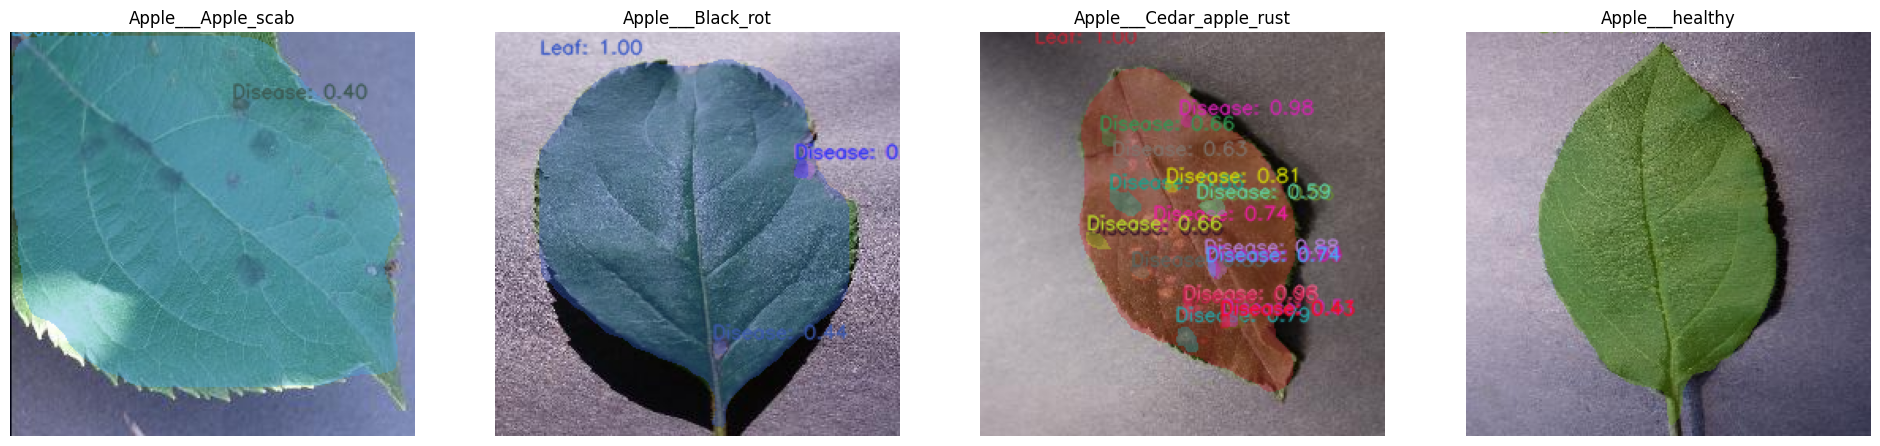

In [29]:
# path = 'apple_leaf_dataset/rcnn/valid_rcnn'
# target_folder = os.listdir(path)

# file = os.listdir( os.path.join( path, target_folder[0]) )[50]
# file
from torchvision import transforms


path = 'apple_leaf_dataset/rcnn/valid_rcnn'
target_folders = os.listdir(path)

fig, axs = plt.subplots( 1, len(target_folders), figsize=(24, 16))
# fig.figure()
# plt.figure(figsize=(24, 16))

for idx, target_folder in enumerate(target_folders):
    file = os.listdir( os.path.join( path, target_folder) )[0]

    model.eval()

    # Load image with OpenCV and convert to RGB
    # img_path = r"apple_leaf_dataset/rcnn/valid_rcnn/Apple___Cedar_apple_rust/5d4e82f2-d720-45fa-b913-13773583ee0f___FREC_C.Rust 4181_180deg.JPG"  # Change this path
    # img_path = f"/run/media/shared_storage/Documents/KuliahUbS1/Semester11_2025_2026/A_Pengolahan_Citra_Digital_dan_Visi_Komputer/tugas_kel_pcdvk/proyek_akhir/apple_leaf_dataset/rcnn/valid_rcnn/Apple___healthy/9b0ebfaf-9d8f-4195-b2af-9505b5bc1f19___RS_HL 6212.JPG"
    img_path = os.path.join(path, target_folder, file)

    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # Transform image to tensor and add batch dimension
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract masks, boxes, labels, and scores
    masks = predictions[0]['masks']       # [N, 1, H, W]
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    threshold = 0.4 #0.4  # Confidence threshold

    # Use overlay for blending masks over image
    overlay = image_bgr.copy()

    for i in range(len(masks)):
        if scores[i] >= threshold:
            # Convert mask to uint8 numpy array (H,W)
            mask = masks[i, 0].mul(255).byte().cpu().numpy()
            mask_bool = mask > 127  # binary mask for indexing
            box = boxes[i].cpu().numpy().astype(int)
            class_name = CLASS_NAMES[labels[i]]
            score = scores[i].item()

            # Generate random color (BGR)
            color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

            # Create colored mask with the random color
            colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
            for c in range(3):
                colored_mask[:, :, c] = mask_bool * color[c]

            # Alpha blend the colored mask onto the overlay
            alpha = 0.4
            overlay = np.where(mask_bool[:, :, None],
                            ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8),
                            overlay)

            # Draw bounding box and label text on overlay
            x1, y1, x2, y2 = box
            # cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1 - 10),
            #             cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, lineType=cv2.LINE_AA)
            cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                        0.4, color, 1, lineType=cv2.LINE_AA)

    # Show the result using matplotlib (convert BGR -> RGB)
    result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    axs[idx].imshow(result_rgb)
    axs[idx].set_title(target_folder)
    axs[idx].axis('off')
plt.show()

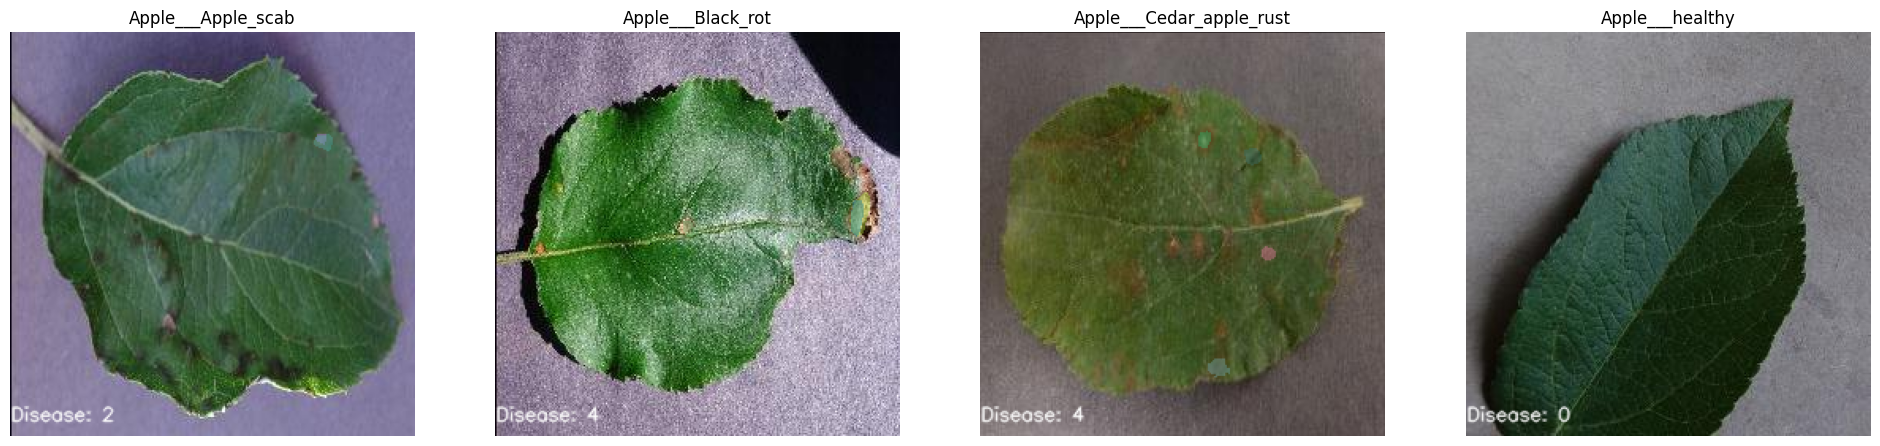

In [41]:
# path = 'apple_leaf_dataset/rcnn/valid_rcnn'
# target_folder = os.listdir(path)

# file = os.listdir( os.path.join( path, target_folder[0]) )[50]
# file
from torchvision import transforms


path = 'apple_leaf_dataset/rcnn/valid_rcnn'
target_folders = os.listdir(path)

fig, axs = plt.subplots( 1, len(target_folders), figsize=(24, 16))
# fig.figure()
# plt.figure(figsize=(24, 16))

for idx, target_folder in enumerate(target_folders):
    file = os.listdir( os.path.join( path, target_folder) )[-1]

    model.eval()

    # Load image with OpenCV and convert to RGB
    # img_path = r"apple_leaf_dataset/rcnn/valid_rcnn/Apple___Cedar_apple_rust/5d4e82f2-d720-45fa-b913-13773583ee0f___FREC_C.Rust 4181_180deg.JPG"  # Change this path
    # img_path = f"/run/media/shared_storage/Documents/KuliahUbS1/Semester11_2025_2026/A_Pengolahan_Citra_Digital_dan_Visi_Komputer/tugas_kel_pcdvk/proyek_akhir/apple_leaf_dataset/rcnn/valid_rcnn/Apple___healthy/9b0ebfaf-9d8f-4195-b2af-9505b5bc1f19___RS_HL 6212.JPG"
    img_path = os.path.join(path, target_folder, file)

    image_bgr = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_pil = Image.fromarray(image_rgb)

    # Transform image to tensor and add batch dimension
    transform = transforms.Compose([transforms.ToTensor()])
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract masks, boxes, labels, and scores
    masks = predictions[0]['masks']       # [N, 1, H, W]
    boxes = predictions[0]['boxes']
    labels = predictions[0]['labels']
    scores = predictions[0]['scores']

    threshold = 0.4 #0.4  # Confidence threshold

    # Use overlay for blending masks over image
    overlay = image_bgr.copy()

    counting = 0
    for i in range(len(masks)):
        if scores[i] >= threshold:
            # Convert mask to uint8 numpy array (H,W)
            mask = masks[i, 0].mul(255).byte().cpu().numpy()
            mask_bool = mask > 127  # binary mask for indexing
            box = boxes[i].cpu().numpy().astype(int)
            class_name = CLASS_NAMES[labels[i]]
            score = scores[i].item()

            if class_name == "Disease":
                counting += 1
            else:
                continue

            # Generate random color (BGR)
            color = np.random.randint(0, 255, (3,), dtype=np.uint8).tolist()

            # Create colored mask with the random color
            colored_mask = np.zeros_like(image_bgr, dtype=np.uint8)
            for c in range(3):
                colored_mask[:, :, c] = mask_bool * color[c]

            # Alpha blend the colored mask onto the overlay
            alpha = 0.4
            overlay = np.where(mask_bool[:, :, None],
                            ((1 - alpha) * overlay + alpha * colored_mask).astype(np.uint8),
                            overlay)

            # Draw bounding box and label text on overlay
            x1, y1, x2, y2 = box
            # cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1 - 10),
            #             cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, lineType=cv2.LINE_AA)
            # cv2.putText(overlay, f"{class_name}: {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
            #             0.4, color, 1, lineType=cv2.LINE_AA)
            
    cv2.putText(overlay, f"Disease: {counting}", (0, overlay.shape[1]-10), cv2.FONT_HERSHEY_SIMPLEX,
                0.4, (255,255,255), 1, lineType=cv2.LINE_AA)
    
    # Show the result using matplotlib (convert BGR -> RGB)
    result_rgb = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    axs[idx].imshow(result_rgb)
    axs[idx].set_title(target_folder)
    axs[idx].axis('off')
plt.show()